In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [31]:
# Define the custom confusion matrix plotting function
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if title:
        plt.title(title)

In [32]:
# # Function to calculate false positive rate and false negative rate from confusion matrix
def calculate_fp_fn_rates(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    return fpr, fnr

In [33]:
df = pd.read_csv("data.csv")
df.shape

(6819, 96)

In [34]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [35]:
df.isnull().sum().sum()

0

In [36]:
df['Bankrupt?'].unique()

array([1, 0])

In [37]:
# Get the counts of each class in the 'dss' column
bankrupt_counts = df['Bankrupt?'].value_counts().reset_index()

# Rename the columns for clarity
bankrupt_counts.columns = ['Class', 'Count']

# Display the DataFrame
bankrupt_counts

,Class,Count
0,0,6599
1,1,220


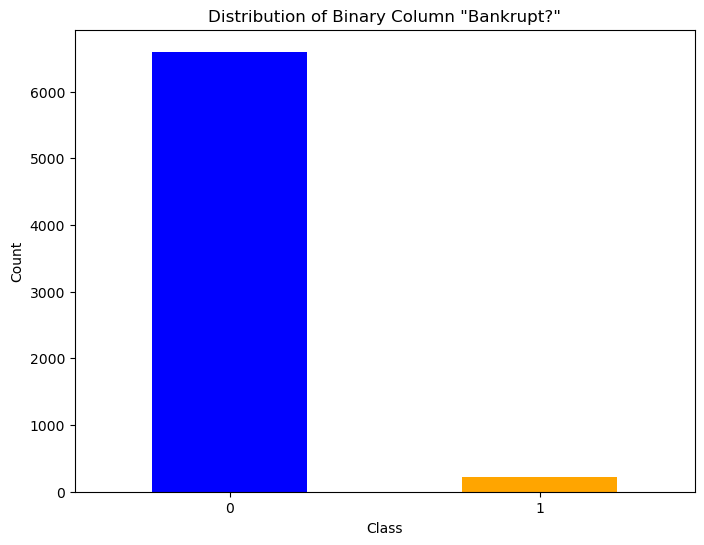

In [38]:
# Plot the distribution of the binary column 'dss'
plt.figure(figsize=(8, 6))
df['Bankrupt?'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Binary Column "Bankrupt?"')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [39]:
X = df.drop(['Bankrupt?'], axis=1)
y = df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)


## Basic Log First

In [40]:
# Create a logistic regression model
basic_lr = LogisticRegression(max_iter=1000, random_state=8)

# Fit the model to the training data
basic_lr.fit(X_train, y_train)

lr_pred = basic_lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, lr_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9530791788856305


In [41]:
initial_coefficients = basic_lr.coef_
initial_coefficients

array([[-5.13620398e-13, -5.73975635e-13, -5.60856669e-13,
        -5.31494027e-13, -5.31414047e-13, -8.50014453e-13,
        -6.77958333e-13, -6.87924477e-13, -2.61005618e-13,
        -6.64432578e-13, -1.42532321e-10, -2.80474525e-10,
        -4.02681659e-13, -4.72458002e-09, -1.46484314e-13,
        -1.93298353e-13, -1.93400529e-13, -1.93341357e-13,
        -2.35092838e-13, -2.81268740e-13, -1.12522685e-08,
        -1.14550918e-13, -1.94773884e-13, -2.09413920e-14,
        -7.25811016e-13, -5.93173159e-13, -5.93096079e-13,
        -1.86368446e-13, -3.46827503e-10,  1.67793342e-07,
        -2.27041822e-13, -3.26162596e-13, -4.20978324e-07,
         2.60106896e-12, -5.39079388e-13, -1.33736291e-10,
        -2.75186366e-14, -8.27044798e-13, -1.08019492e-14,
        -3.06374751e-13, -4.39724733e-15, -1.14175263e-13,
        -1.90580984e-13, -3.38886242e-13, -1.54541288e-13,
        -4.84748755e-07, -5.59522823e-07, -1.98099494e-10,
         2.34338247e-11, -3.17183335e-14,  2.24985343e-0

In [42]:
initial_coefficients = np.ravel(initial_coefficients)
initial_coefficients

array([-5.13620398e-13, -5.73975635e-13, -5.60856669e-13, -5.31494027e-13,
       -5.31414047e-13, -8.50014453e-13, -6.77958333e-13, -6.87924477e-13,
       -2.61005618e-13, -6.64432578e-13, -1.42532321e-10, -2.80474525e-10,
       -4.02681659e-13, -4.72458002e-09, -1.46484314e-13, -1.93298353e-13,
       -1.93400529e-13, -1.93341357e-13, -2.35092838e-13, -2.81268740e-13,
       -1.12522685e-08, -1.14550918e-13, -1.94773884e-13, -2.09413920e-14,
       -7.25811016e-13, -5.93173159e-13, -5.93096079e-13, -1.86368446e-13,
       -3.46827503e-10,  1.67793342e-07, -2.27041822e-13, -3.26162596e-13,
       -4.20978324e-07,  2.60106896e-12, -5.39079388e-13, -1.33736291e-10,
       -2.75186366e-14, -8.27044798e-13, -1.08019492e-14, -3.06374751e-13,
       -4.39724733e-15, -1.14175263e-13, -1.90580984e-13, -3.38886242e-13,
       -1.54541288e-13, -4.84748755e-07, -5.59522823e-07, -1.98099494e-10,
        2.34338247e-11, -3.17183335e-14,  2.24985343e-07, -3.58830430e-13,
       -3.70615783e-07, -

In [43]:
len(initial_coefficients)

95

## Lasso time

In [44]:
# Create a LassoCV model
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline

lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, max_iter=10000, tol=0.001, random_state = 8, n_jobs=-1))

start_time = time.time()
lasso.fit(X_train, y_train)

# Print the chosen alpha
lasso_cv = lasso.named_steps['lassocv']
best_alpha = lasso_cv.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.0037145013358929656


In [45]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=best_alpha))

# Initialize k-fold cross-validation
k = 5 
kf = KFold(n_splits=k, shuffle=True, random_state=8)

# Lists to store metrics and models for each fold
accuracy_scores = []
auc_scores = []
f1_scores = []
models = []

y_train = np.array(y_train)

start_time = time.time()
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the model
    lasso_pipeline.fit(X_train_fold, y_train_fold)

    # Predict on the validation set
    y_val_pred = lasso_pipeline.predict(X_val_fold)

    # Print some debug information
    print(f'Predictions for fold {len(models) + 1}: {y_val_pred[:10]}')
    print(f'Ground truth for fold {len(models) + 1}: {y_val_fold[:10]}')

    # Binarize predictions for classification metrics
    y_val_pred_binary = (y_val_pred > y_val_pred.mean()).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val_fold, y_val_pred_binary)
    auc = roc_auc_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred_binary)

    accuracy_scores.append(accuracy)
    auc_scores.append(auc)
    f1_scores.append(f1)

    # Save the model for this fold
    models.append(lasso_pipeline)

Predictions for fold 1: [ 0.05156977  0.08418169  0.0548692  -0.00083278 -0.05150587  0.01566592
  0.08221605  0.0843656   0.00824335  0.04056193]
Ground truth for fold 1: [0 0 0 0 0 0 0 0 0 0]
Predictions for fold 2: [ 0.00696627  0.02416692  0.02146914 -0.02747937  0.01725677  0.0288793
 -0.01460963 -0.03425329  0.01670336  0.01093235]
Ground truth for fold 2: [0 0 0 0 0 0 0 0 0 0]
Predictions for fold 3: [ 0.20451939  0.04510311  0.00568178  0.04357858 -0.01720437  0.10757132
  0.12686832 -0.02993243  0.07215719  0.01348425]
Ground truth for fold 3: [1 0 0 0 0 0 0 0 0 0]
Predictions for fold 4: [ 0.23533956 -0.02937039 -0.03328249  0.02512131  0.0618821   0.02398076
 -0.03661455  0.00385854  0.00785114  0.05436772]
Ground truth for fold 4: [0 0 0 0 0 0 0 0 0 0]
Predictions for fold 5: [ 0.05323675  0.02988861  0.02419888  0.02878648 -0.02206482  0.06711996
 -0.01459916  0.12348071  0.01105233  0.02727003]
Ground truth for fold 5: [0 0 0 0 0 0 0 0 0 0]


In [46]:

# Print the metrics for each fold
print("\nMetrics for each fold:")
for i in range(k):
    print(f"Fold {i + 1}: Accuracy: {accuracy_scores[i] * 100:.2f}%, AUC: {auc_scores[i] * 100:.2f}%, F1 Score: {f1_scores[i] * 100:.2f}%")

# Calculate and print mean and standard deviation of the metrics
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f'\nMean Accuracy: {mean_accuracy * 100:.2f}% ± {std_accuracy * 100:.2f}%')
print(f'Mean AUC: {mean_auc * 100:.2f}% ± {std_auc * 100:.2f}%')
print(f'Mean F1 Score: {mean_f1 * 100:.2f}% ± {std_f1 * 100:.2f}%')

# Normalize the scores safely
def normalize(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    if max_score - min_score == 0:
        return np.zeros_like(scores)
    return (scores - min_score) / (max_score - min_score)

normalized_accuracy = normalize(accuracy_scores)
normalized_auc = normalize(auc_scores)
normalized_f1 = normalize(f1_scores)

# Combine the scores
combined_scores = normalized_accuracy + normalized_auc + normalized_f1
best_fold_index = np.argmax(combined_scores)  # Use combined score to determine the best fold
best_model = models[best_fold_index]

print(f'\nBest fold: {best_fold_index + 1} with Accuracy: {accuracy_scores[best_fold_index] * 100:.2f}%, AUC: {auc_scores[best_fold_index] * 100:.2f}%, F1 Score: {f1_scores[best_fold_index] * 100:.2f}%')

# Use the best model to make predictions
# Example prediction: best_model.predict(new_data)


Metrics for each fold:
Fold 1: Accuracy: 58.02%, AUC: 92.13%, F1 Score: 11.24%
Fold 2: Accuracy: 61.78%, AUC: 93.61%, F1 Score: 16.10%
Fold 3: Accuracy: 62.60%, AUC: 92.29%, F1 Score: 16.05%
Fold 4: Accuracy: 60.04%, AUC: 95.37%, F1 Score: 12.80%
Fold 5: Accuracy: 59.58%, AUC: 90.85%, F1 Score: 11.62%

Mean Accuracy: 60.40% ± 1.63%
Mean AUC: 92.85% ± 1.54%
Mean F1 Score: 13.56% ± 2.11%

Best fold: 2 with Accuracy: 61.78%, AUC: 93.61%, F1 Score: 16.10%


In [47]:
# Predict on test data and time
y_pred = lasso_pipeline.predict(X_test)
end_time = time.time()

### Understanding Thresholds in the `roc_curve` Function

The `roc_curve` function from `sklearn.metrics` evaluates the performance of a binary classifier by examining various thresholds. Here's how it determines and uses these thresholds:

1. **Predicted Probabilities (`y_pred`):**
   - These are the continuous output values from your classifier, representing the probability or confidence that a given instance belongs to the positive class.

2. **Unique Sorted Thresholds:**
   - The `roc_curve` function extracts all unique values from `y_pred` and sorts them in descending order. These unique values become the candidate thresholds.
   
3. **Threshold Evaluation:**
   - For each unique threshold, the function calculates the True Positive Rate (TPR) and False Positive Rate (FPR).
   - By iterating over the sorted unique values, the function evaluates the classifier's performance at each threshold.

AUC: 0.9257273866860197
Optimal threshold (Youden's J): 0.07393846284650442
Optimal threshold (Distance): 0.07393846284650442


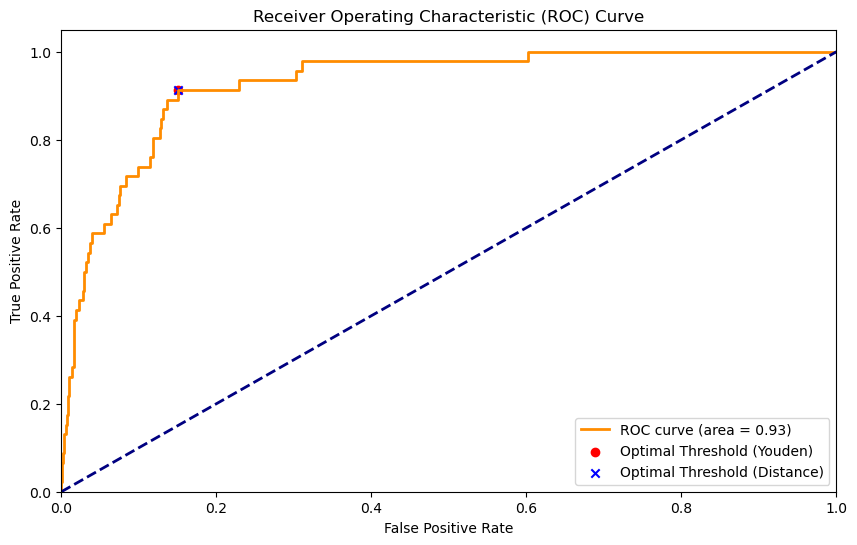

In [48]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Find the optimal threshold by maximizing Youden's J statistic
optimal_idx_youden = np.argmax(tpr - fpr)
optimal_threshold_youden = thresholds[optimal_idx_youden]
print("Optimal threshold (Youden's J):", optimal_threshold_youden)

# Find the optimal threshold by minimizing the distance to the top-left corner (0, 1)
optimal_idx_distance = np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))
optimal_threshold_distance = thresholds[optimal_idx_distance]
print("Optimal threshold (Distance):", optimal_threshold_distance)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot the optimal points
plt.scatter(fpr[optimal_idx_youden], tpr[optimal_idx_youden], marker='o', color='red', label='Optimal Threshold (Youden)')
plt.scatter(fpr[optimal_idx_distance], tpr[optimal_idx_distance], marker='x', color='blue', label='Optimal Threshold (Distance)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [49]:
# Set the threshold
threshold = optimal_threshold_youden

# Convert continuous outputs to binary
binary_outputs = (y_pred >= threshold).astype(int)

# print("Continuous outputs:", y_pred)
# print("Binary outputs:", binary_outputs)

In [50]:
# Access the Lasso model within the pipeline and get its coefficients
lasso_model = lasso_pipeline.named_steps['lasso']
lasso_coefficients = lasso_model.coef_
lasso_coefficients

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.43786168e-03, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.38901626e-03,
       -0.00000000e+00, -9.68844761e-05, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        2.81682244e-02, -2.68651584e-16,  0.00000000e+00,  7.77581481e-03,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -2.14807832e-04, -0.00000000e+00, -0.00000000e+00,
        4.61589799e-03, -4.07436224e-03,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [51]:
len(lasso_coefficients)

95

In [52]:
# Print list of new coefficients of all features
lasso_coefficients_df = pd.DataFrame({'Feature': X.columns, 'LassoCV_Coefficient': lasso_coefficients})
lasso_coefficients_df

,Feature,LassoCV_Coefficient
0,ROA(C) before interest and depreciation befor...,-0.00000
1,ROA(A) before interest and % after tax,-0.00000
2,ROA(B) before interest and depreciation after...,-0.00000
3,Operating Gross Margin,0.00000
4,Realized Sales Gross Margin,0.00000
...,...,...
90,Liability to Equity,0.00000
91,Degree of Financial Leverage (DFL),-0.00000
92,Interest Coverage Ratio (Interest expense to ...,-0.00000
93,Net Income Flag,0.00000


In [53]:
# Check the shape of the arrays
print("Initial coefficients shape:", initial_coefficients.shape)
print("Lasso coefficients shape:", lasso_coefficients.shape)

Initial coefficients shape: (95,)
Lasso coefficients shape: (95,)


In [54]:
# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': np.arange(len(X.columns)),
    'Feature': X.columns,
    'Initial_Coefficients': initial_coefficients,
    'Lasso_Coefficients': lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Lasso_Coefficients'] == 0]['Feature_Index']

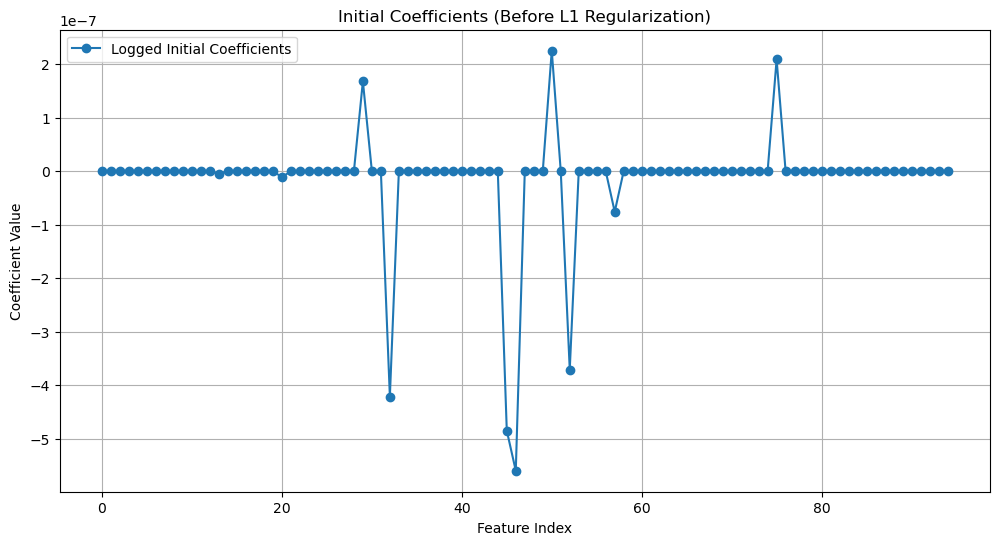

In [61]:
# Plot logged initial coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Initial_Coefficients'], marker='o', label='Logged Initial Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Initial Coefficients (Before L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()


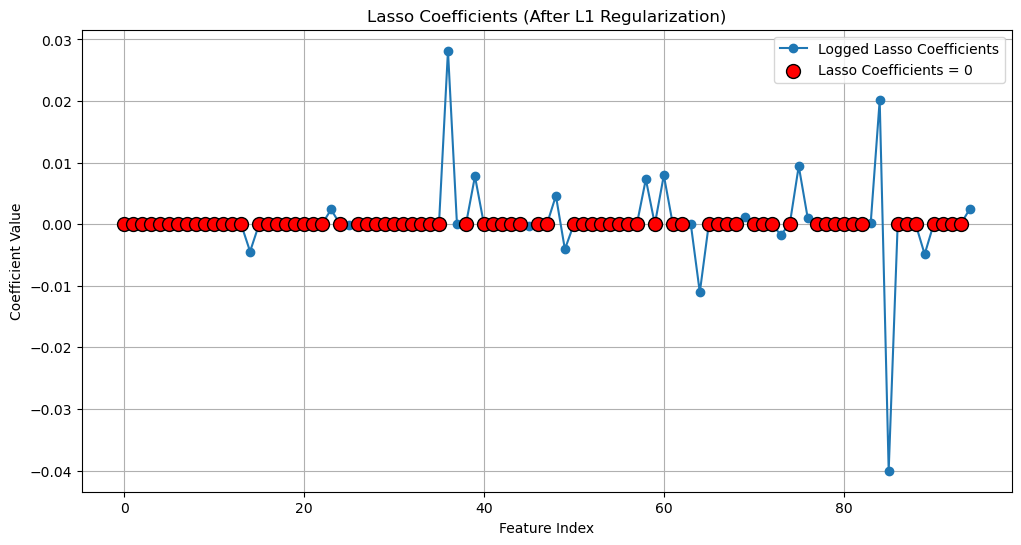

In [62]:

# Plot logged Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# Filter the DataFrame to keep only the non-zero Lasso coefficients
non_zero_coefficients_df = coefficients_df[coefficients_df['Lasso_Coefficients'] != 0]

# Display the filtered DataFrame
non_zero_coefficients_df.shape

(22, 4)

In [57]:
non_zero_coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
14,14,Tax rate (A),-1.464843e-13,-4.437862e-03
23,23,Realized Sales Gross Profit Growth Rate,-2.094139e-14,2.389016e-03
25,25,After-tax Net Profit Growth Rate,-5.931732e-13,-9.688448e-05
36,36,Debt ratio %,-2.751864e-14,2.816822e-02
37,37,Net worth/Assets,-8.270448e-13,-2.686516e-16
39,39,Borrowing dependency,-3.063748e-13,7.775815e-03
45,45,Accounts Receivable Turnover,-4.847488e-07,-2.148078e-04
48,48,Fixed Assets Turnover Frequency,2.343382e-11,4.615898e-03
49,49,Net Worth Turnover Rate (times),-3.171833e-14,-4.074362e-03
58,58,Cash/Current Liability,2.364948e-10,7.302680e-03


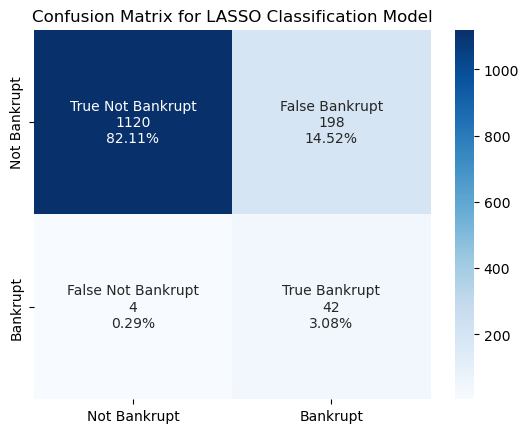

In [58]:
lasso_report = classification_report(y_test, binary_outputs, output_dict=True)

# Compute the confusion matrix
cf_matrix = confusion_matrix(y_test, binary_outputs)

# Define the category names
categories = ['Not Bankrupt', 'Bankrupt']
labels = ['True Not Bankrupt', 'False Bankrupt', 'False Not Bankrupt', 'True Bankrupt']
# Plot the confusion matrix
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      title='Confusion Matrix for LASSO Classification Model')
plt.show()

In [59]:
lasso_metrics = []
# LassoCV model metrics
fpr, fnr = calculate_fp_fn_rates(cf_matrix)
lasso_metrics.append({
    'model': 'Lasso',
    'estimation_time_sec': round(end_time - start_time, 3),
    'accuracy': round(lasso_report['accuracy'], 3),
    'f1-score': round(lasso_report['weighted avg']['f1-score'], 3),
    'auc': round(roc_auc, 3),
    'false_positive_rate': round(fpr, 3),
    'false_negative_rate': round(fnr, 3)
})

lasso_metrics_df = pd.DataFrame(lasso_metrics)
lasso_metrics_df

,model,estimation_time_sec,accuracy,f1-score,auc,false_positive_rate,false_negative_rate
0,Lasso,0.216,0.852,0.896,0.926,0.15,0.087


In [60]:
# write to csv
lasso_metrics_df.to_csv('metrics.csv', index=False)